In [289]:
import pandas as pd
import seaborn as sns

%load_ext autoreload
%autoreload 2

import matplotlib.pylab as plt
import os
import numpy as np
from tqdm import *
from helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [290]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

# Load the data 

In [291]:
orders = pd.read_csv('orders',
                     header=None,
                     names=['id', 'user_id', 'period_id', 'sku', 'num'])
customers = pd.read_csv('users',
                        header=None,
                        names=['user_id','channel'])

orders = orders.merge(customers,on='user_id')
web = pd.read_csv('web',header=None,error_bad_lines=False,iterator=True,chunksize=int(1e5),
                  names=['event_id', 'collector_tstamp', 'domain_userid', 'network_userid', 
                  'user_id', 'page_urlpath', 'refr_medium', 'refr_source', 'mkt_medium', 
                  'mkt_source', 'useragent'])
login_web = pd.read_csv('login_web.csv')

# Customer aquisition

The customer aquisition is an important metric for gousto. Let's take a look at how it has evolved during the given period. To keep it simple, I am going to assume that the website launched on october 1st, 2014. This way, each event associated with a new user_id corresponds to a new aquisition.

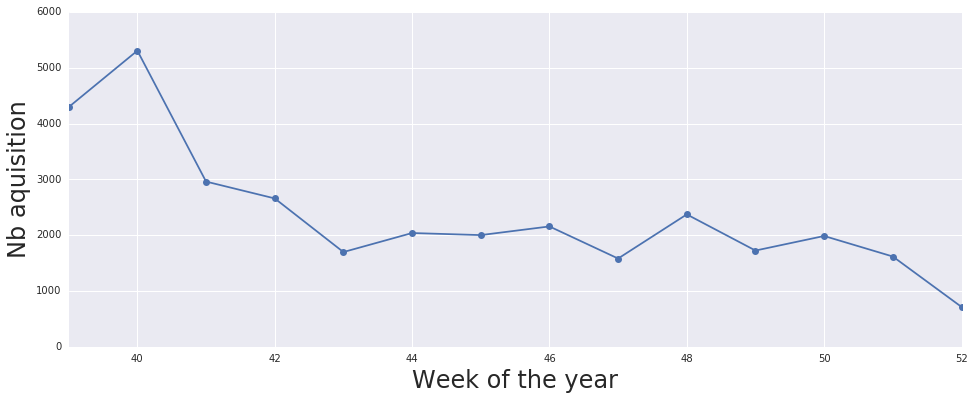

In [281]:
fig = plt.figure(figsize=(16,6))
ax = plt.subplot()
aquisition = pd.read_csv('aquisition.csv',parse_dates=[0,1]).set_index('date_in')
aquisition.groupby('week').size().plot(marker='o',ax=ax)
ax.set_xlabel('Week of the year',fontsize=24)
ax.set_ylabel('Nb aquisition',fontsize=24)

The initial anomaly is due to our way of computing aquisition which makes the assumption that the website was launched 1st of october. Overall the number of acquisitons is relatively constant, 2000/weeks. We can also see a slight decrease toward the end of the year. How does this varies by channel ?

In [282]:
aquisition_by_channel = pd.read_csv('aquisition_by_channel.csv')

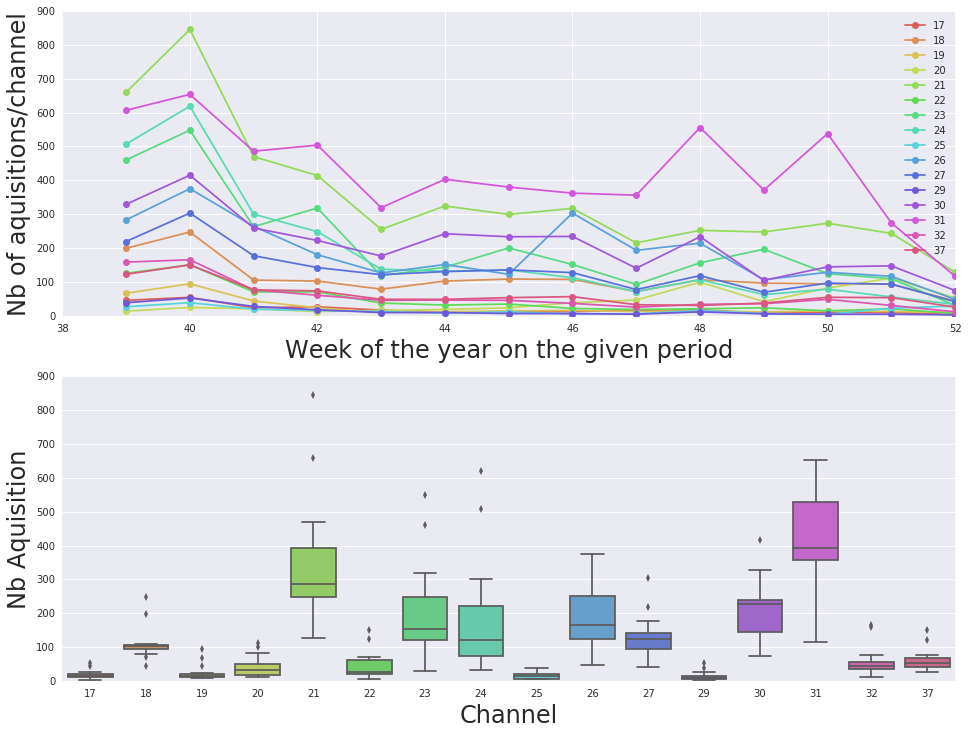

In [29]:
aquisition_by_channel = pd.read_csv('aquisition_by_channel.csv')
fig = plt.figure(figsize=(16,12))
ax = plt.subplot(211)
c = sns.color_palette('hls',len(aquisition_by_channel.channel.unique()))
for i,(name,chan) in enumerate(aquisition_by_channel.groupby('channel')):
    ax.plot(chan.week,chan.NbAquisition,label=name,c=c[i],marker='o')
ax.set_xlabel('Week of the year on the given period',fontsize=24)
ax.set_ylabel('Nb of aquisitions/channel',fontsize=24)
ax.legend()
ax = plt.subplot(212)
sns.boxplot(data=aquisition_by_channel,x="channel",y="NbAquisition",ax=ax,palette='hls')
ax.set_ylabel('Nb Aquisition',fontsize=24)
ax.set_xlabel('Channel',fontsize=24)

Insights from this plot:
- Different channels contribute differently to the nb of aquisition
- Channel 31 and 21 dominates the newcomers
- A few channels, like 17 or 19, are not engaged at all by the website.


# What fraction of users are gousto engaging ?

Let's first compute the fraction of web activity that comes from users that have never register to the website.

In [ ]:
notusers = pd.read_csv('notusers.csv')

In [ ]:
len(login_web)/(len(notusers)+len(login_web))

In reality, only 41% of the web activity on the website is associated with users that have registered during the given time period. The reamaining 60% represents the amount of web activty associated with potential customers that have not been engaged by the website. That's quite a lot.

Unfortunately, it is hard to get more insights on these customers as domain_userid/network_userid are not sufficient to uniquely identified a particular user (user_id is in average associated with 26 possible combinations of network/domain userids..) 

In [33]:
login_web['fake_id'] = login_web.domain_userid+login_web.network_useridb
login_web.groupby('user_id').apply(lambda df:len(df.fake_id)).describe()

count    33118.000000
mean        26.951597
std         35.997879
min          1.000000
25%          6.000000
50%         14.000000
75%         34.000000
max       1170.000000
dtype: float64

Instead of this, let's focus on the customers that have indeed registered on the website during the given period. In addition, to forgive myself the pain of tracking back the web activity of customer registered late in the given period, we will focus on the web activity of registered users since the time they have first logged in the website for simplicity. 

# What fraction of these users are actually ordering boxes ?

We didn't touch to the orders data yet but it looks like now is a good time.

In [4]:
p = len(login_web[login_web.user_id.isin(orders.user_id.unique())].user_id.unique())/len(login_web.user_id.unique())
print('{}% of the registered users are actually ordering boxes'.format(p))

0.16072830484932665% of the registered users are actually ordering boxes


Only 15% of the users seems to have actually purchased boxes during the given period. For those who effectively buy something, we can see that most of them buy only 1 box in the given period which spans 13 weeks.

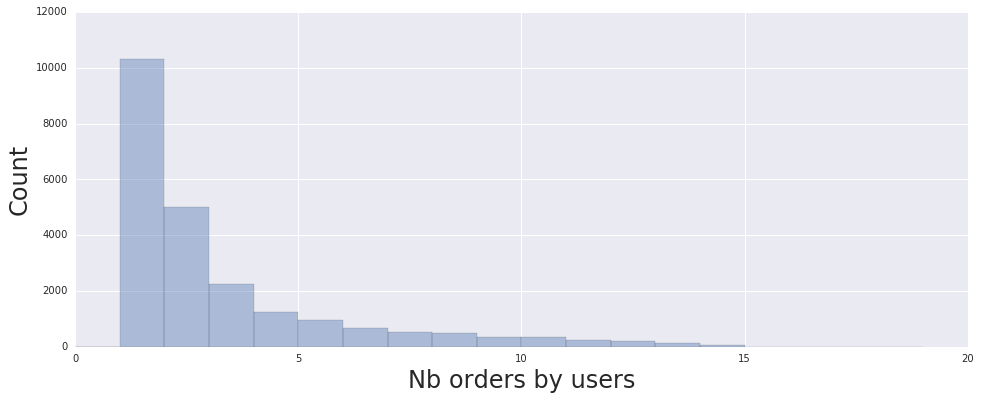

In [5]:
fig = plt.figure(figsize=(16,6))
ax = plt.subplot()
df = orders.groupby(['user_id']).size().reset_index(name='N')
sns.distplot(df.N,ax=ax,bins=range(20),kde=False)
ax.set_xlabel('Nb orders by users',fontsize=24)
ax.set_ylabel('Count',fontsize=24)

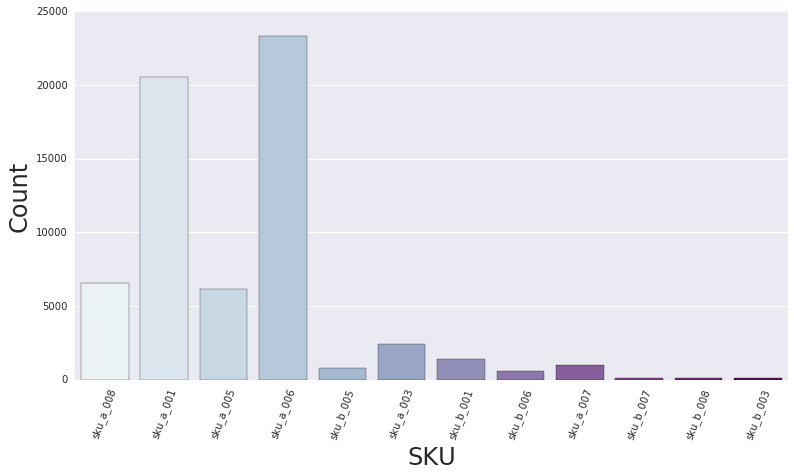

In [6]:
g = sns.factorplot(x="sku", data=orders, kind="count",
                   palette="BuPu",size=6,aspect=1.8)
d = plt.setp( g.ax.xaxis.get_majorticklabels(), rotation=70 )
g.ax.set_xlabel('SKU',fontsize=24)
g.ax.set_ylabel('Count',fontsize=24)

Above, we can see that orders are heavily bias toward a few recipees. Indeed, while a few recipees are very popular (1 and 6), most of them are very rarely ordered. One of the reason might be that these recipee appear late in the given period. Let's take a look at the week level.

When grouping by week, we observe that only 15 of the 30 period_id/week actually contains data. My explanation for that is that this dataset is the result of an A/B testing campaign, with a testing period where very few users are reroot to this new website, and when everything is working properly, a reasonable amount of customers is rerooted to this new website. Expect my intuition, I don't have a lot to support that claim. In addition, we still have 15 weeks worth of data and only 13 weeks of web activity. As they are supposed to overlap, there is clearly something I am missing here.

I tried to select those weeks with more than 3000, 13 weeks, and joined them to the web activty but I ended up with a very few events at the end. I then decided to focus only on the web activity in the following. 

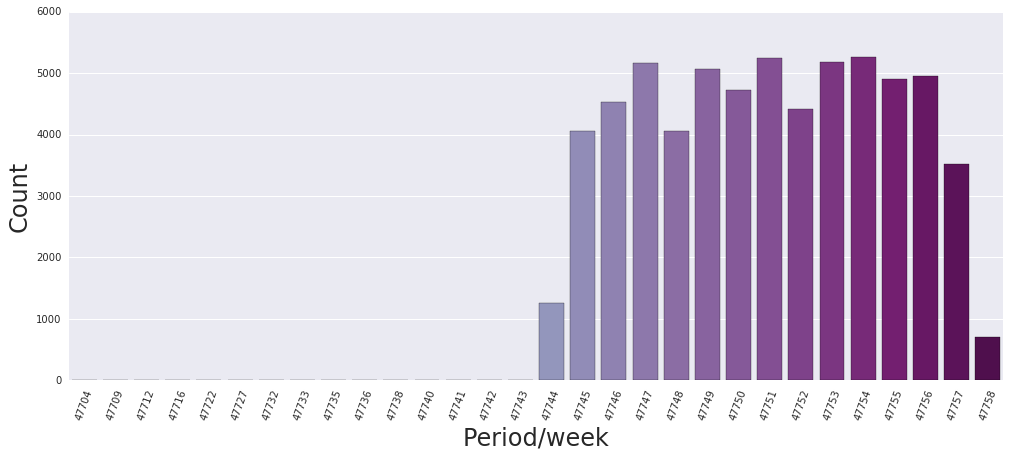

In [8]:
g = sns.factorplot(x="period_id", data=orders, kind="count",
                   palette="BuPu",size=6,aspect=2.3)
d = plt.setp( g.ax.xaxis.get_majorticklabels(), rotation=70 )
g.ax.set_xlabel('Period/week',fontsize=24)
g.ax.set_ylabel('Count',fontsize=24)

##  Customer behavior 

In the following, let's try to understand if there are any differences in the behavior of customers that are ordering boxes and those who are not. Such difference, if identified, could help building a customer engagment predictive model based solely on web activity. 

Let's first look at the period of activity, defined as the time between the first time they login and their last visit (at most 92 days).

In [284]:
activity_period = pd.read_csv('activity_period.csv')
activity_period['has_order'] = activity_period.user_id.isin(orders.user_id)

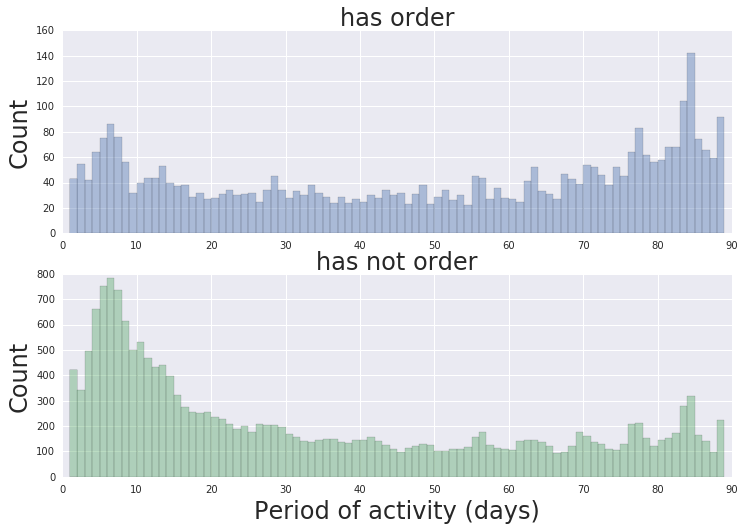

In [285]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(211)
sns.distplot(activity_period[activity_period.has_order].period_of_activity,kde=False,
             bins=range(1,90),color=sns.color_palette('deep')[0])
ax.set_xlabel('',fontsize=24)
ax.set_ylabel('Count',fontsize=24)
ax.set_title('has order',fontsize=24)
ax = plt.subplot(212)
ax.set_title('has not order',fontsize=24)
sns.distplot(activity_period[~activity_period.has_order].period_of_activity,
             kde=False,bins=range(1,90),color=sns.color_palette('deep')[1])
ax.set_xlabel('Period of activity (days)',fontsize=24)
ax.set_ylabel('Count',fontsize=24)

In [51]:
activity_period.groupby('has_order').period_of_activity.mean()

has_order
False    22.990322
True     34.598723
Name: period_of_activity, dtype: float64

As expected, users that have not order anything have a period of activity which picks between 0 and 10 days. Surprisingly though, a lot of users still live in the tail of this distribution. Are they using the website as a cookbook ??

In [63]:
cook = pd.read_csv('use_has_cookbook.csv')
cook.proportion.mean()

0.024147744219092188

Actually, for these users, the events that involve the cookbook represents only 0.02% of the total number of events. Then, not really.

Another interesting thing to look at is the number of times a user connects on the website on average. In the following, I'll consider a new connection when the user connects after 5 min of inactivity.

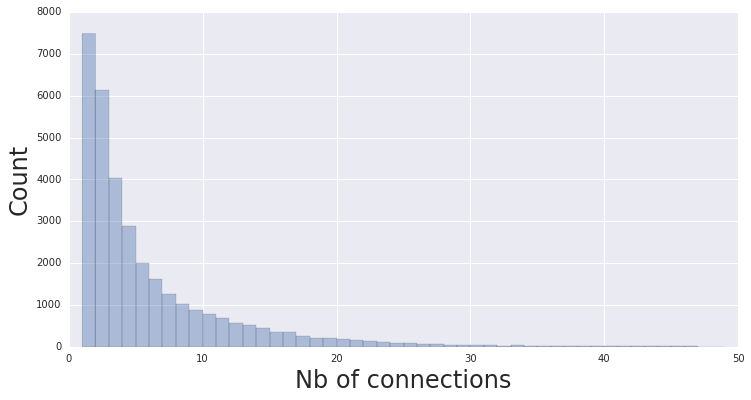

In [292]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot()
nconnection = pd.read_csv('nconnection.csv')
sns.distplot(nconnection.N,kde=False,bins=range(1,50),ax=ax)
ax.set_xlabel('Nb of connections',fontsize=24)
ax.set_ylabel('Count',fontsize=24)

As shown above, the distribution of the nb of connections seems to follow an exponential distribution. The mean number of connections if ~5, which is below the optimal 13 connections, one by week, if every users was ordering something. 

Digging deeper in the customer behavior, let's look at the difference in the mean number of events by connection between user that order something and those who not. 

(0, 10)

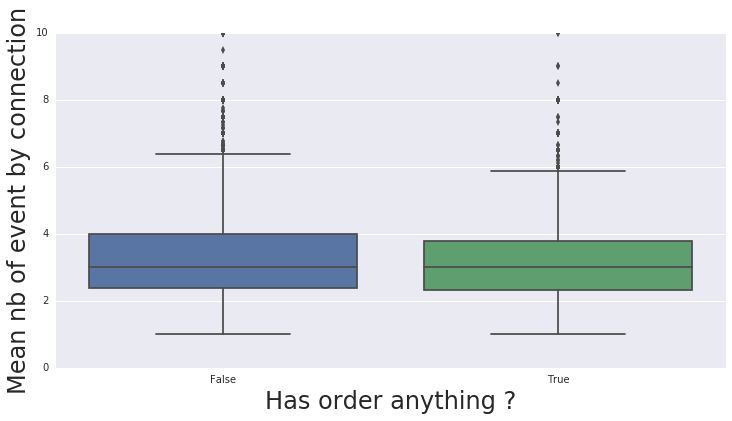

In [130]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot()
df = pd.read_csv('info_connections.csv')
df['has_order']=df.user_id.isin(orders.user_id)
sns.boxplot(y='mean_nb_of_event_by_connection',x='has_order',data=df)
ax.set_xlabel('Has order anything ?',fontsize=24)
ax.set_ylabel('Mean nb of event by connection',fontsize=24)
ax.set_ylim(0,10)

On average, a gousto user is associated with 3 events at each connection. As shown above, there is not much difference between the users that order something and those who not. What about the mean connection time?

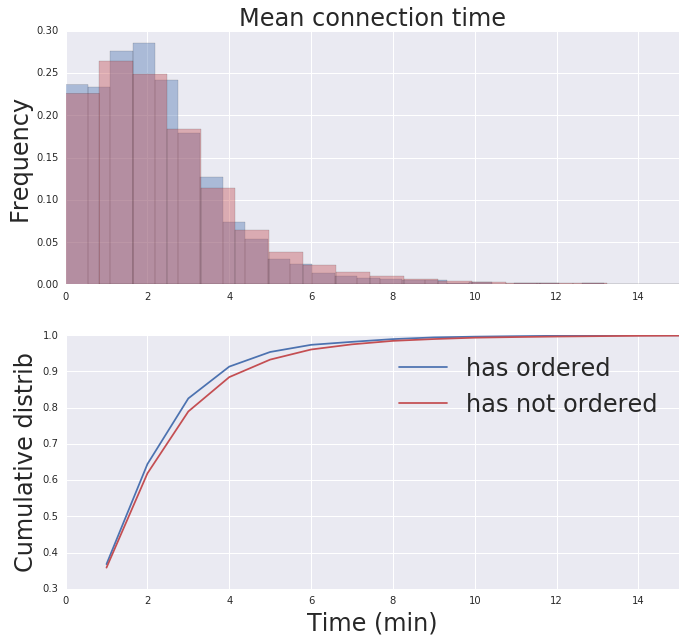

In [286]:
df = pd.read_csv('info_connections.csv')
df['has_order']=df.user_id.isin(orders.user_id)
df['mean_connection_time2']=(df.mean_connection_time/60).round()
pmforder = get_pmf(df[df.has_order].groupby(df.mean_connection_time2).size())
pmfnotorder = get_pmf(df[~df.has_order].groupby(df.mean_connection_time2).size())
fig  = plt.figure(figsize=(11,10))
ax = plt.subplot(211)
c = sns.color_palette('deep',3)
sns.distplot(df[df.has_order].mean_connection_time/60,kde=False,ax=ax,norm_hist=True,color=c[0])
sns.distplot(df[~df.has_order].mean_connection_time/60,kde=False,ax=ax,norm_hist=True,color=c[2])
ax.set_xlim(0,15)
ax.set_ylabel('Frequency',fontsize=24)
ax.set_xlabel('',fontsize=24)
ax.set_title('Mean connection time',fontsize=24)
ax = plt.subplot(212)
x = range(1,60)
ax.plot(x,pmforder.cdf(x),color=c[0],label='has ordered')
ax.plot(x,pmfnotorder.cdf(x),color=c[2],label='has not ordered')
ax.set_xlim(0,15)
ax.set_ylabel('Cumulative distrib',fontsize=24)
ax.set_xlabel('Time (min)',fontsize=24)
ax.legend(fontsize=24)

Even if the different is probably not significant, we can see here that the users that have ordered something in the given period spend slightly less time (clearer on the cumulative distribution) on the website at each connection.

Finally, we can look at the mean time between two connections.

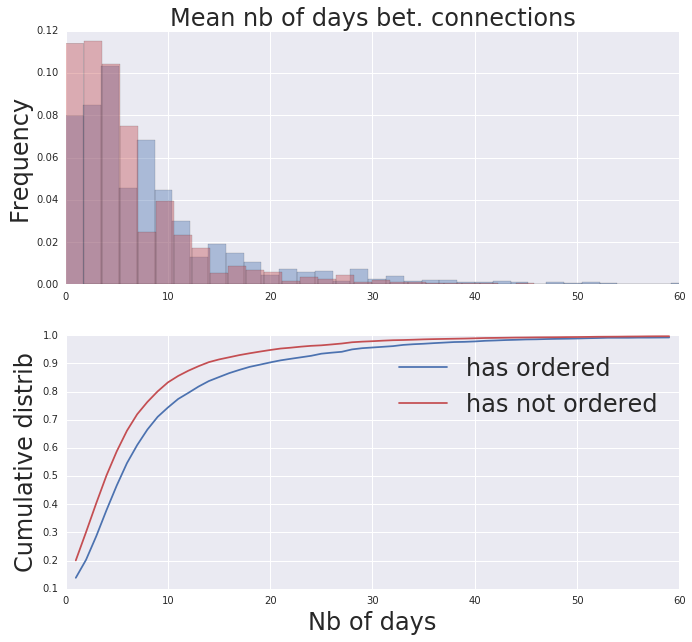

In [244]:
df = df[df.mean_time_bet_connection>=0]
pmforder = get_pmf(df[df.has_order].groupby(df.mean_time_bet_connection).size())
pmfnotorder = get_pmf(df[~df.has_order].groupby(df.mean_time_bet_connection).size())
fig  = plt.figure(figsize=(11,10))
ax = plt.subplot(211)
c = sns.color_palette('deep',3)
sns.distplot(df[df.has_order].mean_time_bet_connection,kde=False,ax=ax,norm_hist=True,color=c[0])
sns.distplot(df[~df.has_order].mean_time_bet_connection,kde=False,ax=ax,norm_hist=True,color=c[2])
ax.set_xlim(0,60)
ax.set_ylabel('Frequency',fontsize=24)
ax.set_xlabel('',fontsize=24)
ax.set_title('Mean nb of days bet. connections',fontsize=24)
ax = plt.subplot(212)
x = range(1,60)
ax.plot(x,pmforder.cdf(x),color=c[0],label='has ordered')
ax.plot(x,pmfnotorder.cdf(x),color=c[2],label='has not ordered')
ax.set_xlim(0,60)
ax.set_ylabel('Cumulative distrib',fontsize=24)
ax.set_xlabel('Nb of days',fontsize=24)
ax.legend(fontsize=24)

The number of days between two connections appear larger for people that have ordered something on the website. Unfortunately, even if the difference is clearer with this metric, the correlation is probably not sufficient to build a model with only those features.

In [288]:
corr = df[[f for f in df.columns if f not in ['user_id','mean_connection_time2']]].corr()['has_order']
corr

mean_time_bet_connection          0.079462
mean_connection_time             -0.031133
mean_nb_of_event_by_connection   -0.027431
has_order                         1.000000
Name: has_order, dtype: float64

# Summary and actionable insights 

We have explore the web activity of Gousto customers during the last three months of 2014. 
The main insights that comes out of this study are:
- The number of aquisitions was relatively constant during these three months
- The website is engaging new customers only through a few channels.
- Only a small fraction of customers is buying boxes and some efforts should be put in trying to better engaging the users that have registered to the website.
- Those who buy something tend to stick to 3 or 4 recipees. Based on this information, Gousto might reduce the number of choices proposed to the customers. 
- Even if some difference exist between the customer behavior of those who buy anything and those who not, they are probably too weak to support any predictive modelling. 